In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joblib

# import section of ML part
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV


# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier  # XGBoost
from catboost import CatBoostClassifier, Pool

from sklearn.decomposition import PCA, FactorAnalysis

from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

%load_ext jupyternotify 
# // add command at the top of necessary cell: %%notify 

import warnings
warnings.filterwarnings('ignore')

<IPython.core.display.Javascript object>

<h3>Set of functions used in feature engineering</h3>

In [3]:
def add_price_change_features(df, price_col='сlose'):
    """
    Adds return-based features to the dataframe for modeling.
    """
    df = df.copy()
    
    # Daily returns (can be used as target or feature)
    for n in [1, 3, 7]:
        df[f'return_{n}d'] = df[price_col].pct_change(n)

    # Lagged returns (past signals as features)
    for n in [1, 3, 7]:
        df[f'return_{n}d_lag1'] = df[f'return_1d'].shift(n)

    return df


def calculate_rsi(df, column='close', period=14):
    """
    Calculate the Relative Strength Index (RSI) for a given stock price data.
    
    Parameters:
    - data (pd.DataFrame): DataFrame containing stock price data.
    - column (str): The column name containing closing prices.
    - period (int): The lookback period for RSI calculation (default: 14).
    
    Returns:
    - pd.DataFrame: with RSI indicators incorporated.
    """
    df[['RSI_overbought', 'RSI_oversold', 'RSI_neutral']] = 0
    delta = df[column].diff(1)  # Calculate daily price changes

    # Separate gains and losses
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate rolling average of gains and losses
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    # Compute the Relative Strength (RS) and RSI
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    df['RSI'] = rsi
    df.loc[df['RSI'] > 70, ['RSI_overbought']] = 1
    df.loc[df['RSI'] < 70, ['RSI_oversold']] = 1
    df.loc[(df['RSI'] < 70) & (df['RSI'] > 30), ['RSI_neutral']] = 1
    
    return df

def calculate_macd(df, column='close', short_period=12, long_period=26, signal_period=9):
    """
    Calculate the MACD (Moving Average Convergence Divergence) for a given stock price data.

    Parameters:
    - df (pd.DataFrame): DataFrame containing stock price data.
    - column (str): The column name containing closing prices.
    - short_period (int): The short-term EMA period (default: 12).
    - long_period (int): The long-term EMA period (default: 26).
    - signal_period (int): The signal line EMA period (default: 9).

    Returns:
    - pd.DataFrame: DataFrame with MACD line, Signal line, and MACD Histogram.
    """
    # Compute the short-term and long-term EMAs
    short_ema = df[column].ewm(span=short_period, adjust=False).mean()
    long_ema = df[column].ewm(span=long_period, adjust=False).mean()

    # Calculate MACD line
    macd_line = short_ema - long_ema

    # Calculate Signal line (9-day EMA of MACD line)
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()

    # Calculate MACD Histogram
    macd_histogram = macd_line - signal_line

    # Add results to DataFrame
    df['MACD_Histogram'] = macd_histogram

    df['MACD_signal'] = 0
    df.loc[df['MACD_Histogram'] > 0, ['MACD_signal']] = 1

    
    return df

In [4]:
# support functions

def run_grid_search(model, param_grid, X_train, y_train, scoring='f1', cv=5, verbose=1, n_jobs=-1):
    """
    Runs GridSearchCV for a given model and parameter grid.
    
    Parameters:
    - model: estimator object (e.g., LogisticRegression())
    - param_grid: dictionary of hyperparameters to search
    - X_train: training features
    - y_train: training target
    - scoring: metric for evaluation (default='f1')
    - cv: number of cross-validation folds (default=5)
    - verbose: verbosity level (default=1)
    - n_jobs: number of parallel jobs to run (default=-1 = all cores)
    
    Returns:
    - best_score: best cross-validated score
    - best_params: dictionary of best parameters found
    """
    grid = GridSearchCV(estimator=model,
                        param_grid=param_grid,
                        scoring=scoring,
                        cv=cv,
                        verbose=verbose,
                        n_jobs=n_jobs)

    grid.fit(X_train, y_train)

    return grid.best_score_, grid.best_params_

def plot_roc_auc(y_true, y_scores, model_name='Model'):
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    auc_score = roc_auc_score(y_true, y_scores)

    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name} - optimal threshold is: {optimal_threshold:.2f}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return

<h2>Development of a classification model</h2>

The goal of this notebook is to develop a classifier which would predict next stock price movement based on available stock price data. Once trained, the classifier will be used in a stock market dashboard for prediction.

I'm interested in prediction of whether price is to go up or down, which makes a binary classification task.

In [6]:
stock_data = pd.read_csv('AAPL.csv', parse_dates=['date'], index_col='date')
display(stock_data.info())
display(stock_data.head(10))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6398 entries, 1999-11-01 to 2025-04-10
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6398 non-null   int64  
 1   open        6398 non-null   float64
 2   high        6398 non-null   float64
 3   low         6398 non-null   float64
 4   close       6398 non-null   float64
 5   volume      6398 non-null   int64  
 6   symbol      6398 non-null   object 
dtypes: float64(4), int64(2), object(1)
memory usage: 399.9+ KB


None

Unnamed: 0   open   high    low  close   volume symbol
date                                                              
1999-11-01           0  80.00  80.69  77.37  77.62  2487300   AAPL
1999-11-02           1  78.00  81.69  77.31  80.25  3564600   AAPL
1999-11-03           2  81.62  83.25  81.00  81.50  2932700   AAPL
1999-11-04           3  82.06  85.37  80.62  83.62  3384700   AAPL
1999-11-05           4  84.62  88.37  84.00  88.31  3721500   AAPL
1999-11-08           5  87.75  97.73  86.75  96.37  8490400   AAPL
1999-11-09           6  94.37  94.50  88.00  89.62  7224800   AAPL
1999-11-10           7  88.25  93.25  88.12  91.44  5159800   AAPL
1999-11-11           8  91.59  92.62  89.87  92.25  2409600   AAPL
1999-11-12           9  91.94  92.00  87.37  90.62  2491600   AAPL

In [7]:
# deletion of erroneous column Unnamed: 0
stock_data.drop(stock_data.columns[0], inplace=True, axis=1)
stock_data.head()



open   high    low  close   volume symbol
date                                                  
1999-11-01  80.00  80.69  77.37  77.62  2487300   AAPL
1999-11-02  78.00  81.69  77.31  80.25  3564600   AAPL
1999-11-03  81.62  83.25  81.00  81.50  2932700   AAPL
1999-11-04  82.06  85.37  80.62  83.62  3384700   AAPL
1999-11-05  84.62  88.37  84.00  88.31  3721500   AAPL

<h3>Dataset description</h3>

Initial dataset obtained from market data provider AlphaVantage contains daily market data only, ie. data in columns: open, high, low, close, volume and symbol.
<br>
<br>
First, I plot the price movements to check for any potential issues.

<Axes: xlabel='date'>

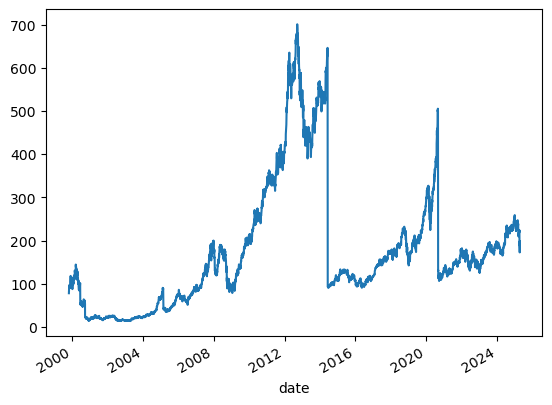

In [9]:
stock_data['close'].plot()

Significant drops in share prices are most likely connected with some corporate actions but not market events. Based on public information we can see that there were four share splits within the available time range. So, I will adjust the prices for these events, since the various indicators will be distorted.

<Axes: xlabel='date'>

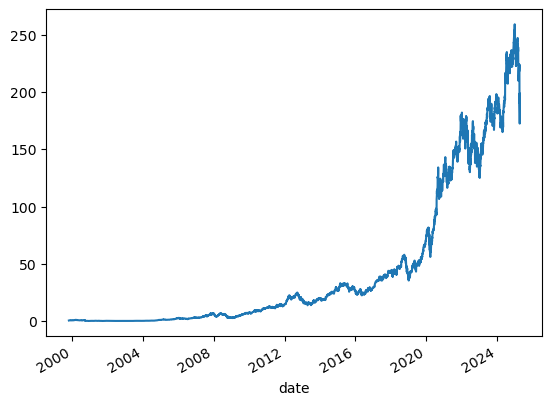

In [11]:
# adjusting for share splits
stock_data.loc[stock_data.index < '2020-08-31', ['open', 'high', 'low', 'close']] /= 4
stock_data.loc[stock_data.index < '2014-06-09', ['open', 'high', 'low', 'close']] /= 7
stock_data.loc[stock_data.index < '2005-02-28', ['open', 'high', 'low', 'close']] /= 2
stock_data.loc[stock_data.index < '2000-06-21', ['open', 'high', 'low', 'close']] /= 2

stock_data['close'].plot()

<h2>Features</h2>
For model development purposes I will enrich the dataset with some additional indicators, which are usually used in stock price analysis such as:
<li>whether current price is above or below 90 and 200 days simple moving average (columns: 90dSMA_ind and 200dSMA_ind)</li>
<li><b>Relative Strength Index</b>, which is transformed into three indicators showing that the share is either overbought (RSI over 70), oversold (RSI below 30) or neutral (RSI between 30 and 70).</li>
<li><b>Moving Average Convergence Divergence (MACD)</b> represented by two values: MACD histogram value and MACD signal</li>
<li><b>Volatility</b> of the stock price within a day, calculated as percentage difference between highest and lowest price on a given day</li>
<li>Lagged values: day change in price occurred 1, 3 and 7 days ago as well as price change for 3 and 7 days periods.</li>

<h2>Target value</h2>
As a target value I will use T+1 price change converted into a binary variable - 1 for increase in price and 0 for reduction.

In [13]:
# calculating 1-day change 
stock_data['target'] = stock_data['close'].pct_change(1).shift(-1)
display(stock_data.tail())
stock_data.head()

open      high       low   close     volume symbol    target
date                                                                       
2025-04-04  193.890  199.8800  187.3400  188.38  125910913   AAPL -0.036734
2025-04-07  177.200  194.1500  174.6200  181.46  160466286   AAPL -0.049818
2025-04-08  186.700  190.3350  169.2101  172.42  120859491   AAPL  0.153288
2025-04-09  171.950  200.6100  171.8900  198.85  184395885   AAPL -0.042394
2025-04-10  189.065  194.7799  183.0000  190.42  121879981   AAPL       NaN

open      high       low     close   volume symbol    target
date                                                                        
1999-11-01  0.714286  0.720446  0.690804  0.693036  2487300   AAPL  0.033883
1999-11-02  0.696429  0.729375  0.690268  0.716518  3564600   AAPL  0.015576
1999-11-03  0.728750  0.743304  0.723214  0.727679  2932700   AAPL  0.026012
1999-11-04  0.732679  0.762232  0.719821  0.746607  3384700   AAPL  0.056087
1999-11-05  0.755536  0.789018  0.750000  0.788482  3721500   AAPL  0.091269

In [14]:
stock_data = add_price_change_features(stock_data, 'close')
stock_data = calculate_rsi(stock_data)
stock_data = calculate_macd(stock_data)

stock_data['volatility'] = stock_data.high.sub(stock_data.low).div(stock_data.high)

# 90d and 200d moving average
stock_data['90dSMA_ind'] = stock_data.close - stock_data.close.rolling(window=90, min_periods=1).mean()
stock_data['200dSMA_ind'] = stock_data.close - stock_data.close.rolling(window=200, min_periods=1).mean()

# replacing SMA vs. price with a binary values
stock_data.loc[stock_data['90dSMA_ind'] > 0, ['90dSMA_ind']] = 1
stock_data.loc[stock_data['90dSMA_ind'] <= 0, ['90dSMA_ind']] = 0

stock_data.loc[stock_data['200dSMA_ind'] > 0, ['200dSMA_ind']] = 1
stock_data.loc[stock_data['200dSMA_ind'] <= 0, ['200dSMA_ind']] = 0

stock_data.tail()

open      high       low   close     volume symbol    target  \
date                                                                          
2025-04-04  193.890  199.8800  187.3400  188.38  125910913   AAPL -0.036734   
2025-04-07  177.200  194.1500  174.6200  181.46  160466286   AAPL -0.049818   
2025-04-08  186.700  190.3350  169.2101  172.42  120859491   AAPL  0.153288   
2025-04-09  171.950  200.6100  171.8900  198.85  184395885   AAPL -0.042394   
2025-04-10  189.065  194.7799  183.0000  190.42  121879981   AAPL       NaN   

            return_1d  return_3d  return_7d  ...  return_7d_lag1  \
date                                         ...                   
2025-04-04  -0.072887  -0.155966  -0.149641  ...       -0.009922   
2025-04-07  -0.036734  -0.189513  -0.189368  ...        0.010473   
2025-04-08  -0.049818  -0.151435  -0.208720  ...       -0.026580   
2025-04-09   0.153288   0.055579  -0.104803  ...        0.019413   
2025-04-10  -0.042394   0.049377  -0.146826  ...        0.004772   

            RSI_overbought  RSI_oversold  RSI_neutral        RSI  \
date                                                               
2025-04-04               0             1            1  30.777311   
2025-04-07               0             1            0  28.387543   
2025-04-08               0             1            0  22.809246   
2025-04-09               0             1            1  42.670384   
2025-04-10               0             1            1  37.141010   

            MACD_Histogram  MACD_signal  volatility  90dSMA_ind  200dSMA_ind  
date                                                                          
2025-04-04       -1.739762            0    0.062738         0.0          0.0  
2025-04-07       -3.112449            0    0.100592         0.0          0.0  
2025-04-08       -4.339011            0    0.110988         0.0          0.0  
2025-04-09       -3.136184            0    0.143163         0.0          0.0  
2025-04-10       -2.691254            0    0.060478         0.0          0.0  

[5 rows x 22 columns]

In [15]:
stock_data.describe()

open         high          low        close        volume  \
count  6398.000000  6398.000000  6398.000000  6398.000000  6.398000e+03   
mean     44.388137    44.872209    43.932550    44.424546  3.351635e+07   
std      62.933229    63.623628    62.307018    63.003471  3.063656e+07   
min       0.231964     0.235536     0.227143     0.234286  7.025000e+05   
25%       2.351250     2.389286     2.309554     2.344732  1.234118e+07   
50%      16.356786    16.474641    16.202679    16.314286  2.515580e+07   
75%      47.503750    47.957500    47.191250    47.583750  4.499851e+07   
max     258.190000   260.100000   257.630000   259.020000  3.326072e+08   

            target    return_1d    return_3d    return_7d  return_1d_lag1  \
count  6397.000000  6397.000000  6395.000000  6391.000000     6396.000000   
mean      0.001192     0.001192     0.003509     0.008176        0.001199   
std       0.024585     0.024585     0.041307     0.062769        0.024581   
min      -0.518692    -0.518692    -0.582991    -0.593458       -0.518692   
25%      -0.009971    -0.009971    -0.017156    -0.025773       -0.009968   
50%       0.000901     0.000901     0.003687     0.009349        0.000903   
75%       0.012721     0.012721     0.024301     0.043510        0.012722   
max       0.153288     0.153288     0.227976     0.310861        0.153288   

       ...  return_7d_lag1  RSI_overbought  RSI_oversold  RSI_neutral  \
count  ...     6390.000000     6398.000000   6398.000000  6398.000000   
mean   ...        0.001215        0.215536      0.784308     0.703188   
std    ...        0.024460        0.411226      0.411334     0.456888   
min    ...       -0.518692        0.000000      0.000000     0.000000   
25%    ...       -0.009933        0.000000      1.000000     0.000000   
50%    ...        0.000916        0.000000      1.000000     1.000000   
75%    ...        0.012725        0.000000      1.000000     1.000000   
max    ...        0.139050        1.000000      1.000000     1.000000   

               RSI  MACD_Histogram  MACD_signal   volatility   90dSMA_ind  \
count  6397.000000     6398.000000  6398.000000  6398.000000  6398.000000   
mean     55.141069       -0.004851     0.518443     0.027170     0.688809   
std      17.600006        0.445597     0.499699     0.018494     0.463017   
min       3.142857       -4.339011     0.000000     0.004135     0.000000   
25%      42.461920       -0.042296     0.000000     0.014762     0.000000   
50%      55.205923        0.000602     1.000000     0.021888     1.000000   
75%      68.312102        0.049254     1.000000     0.033647     1.000000   
max     100.000000        2.379293     1.000000     0.228461     1.000000   

       200dSMA_ind  
count  6398.000000  
mean      0.739294  
std       0.439054  
min       0.000000  
25%       0.000000  
50%       1.000000  
75%       1.000000  
max       1.000000  

[8 rows x 21 columns]

In [16]:
# there is a small number of NaN values due to added lagged values, representing just 8 data points. So, we can
# easily drop them

# in addition, I drop columns which are not useful for the classifier: symbol and all actual prices
stock_data.dropna(axis=0, inplace=True)
stock_data.drop(['open', 'high', 'low', 'close', 'symbol'], axis=1, inplace=True)
stock_data.head()

volume    target  return_1d  return_3d  return_7d  \
date                                                             
1999-11-11  2409600 -0.017669   0.008858  -0.042752   0.149533   
1999-11-12  2491600 -0.013021  -0.017669   0.011158   0.111902   
1999-11-15  2320600  0.019566  -0.013021  -0.021872   0.069601   
1999-11-16  2088000 -0.010308   0.019566  -0.011491   0.032612   
1999-11-17  3255100 -0.006981  -0.010308  -0.004083  -0.063505   

            return_1d_lag1  return_3d_lag1  return_7d_lag1  RSI_overbought  \
date                                                                         
1999-11-11        0.020308        0.091269        0.033883               1   
1999-11-12        0.008858       -0.070043        0.015576               1   
1999-11-15       -0.017669        0.020308        0.026012               0   
1999-11-16       -0.013021        0.008858        0.056087               1   
1999-11-17        0.019566       -0.017669        0.091269               0   

            RSI_oversold  RSI_neutral        RSI  MACD_Histogram  MACD_signal  \
date                                                                            
1999-11-11             0            0  76.004266        0.013534            1   
1999-11-12             0            0  71.841398        0.011351            1   
1999-11-15             1            1  69.101487        0.008518            1   
1999-11-16             0            0  70.755583        0.007075            1   
1999-11-17             1            1  68.777877        0.005030            1   

            volatility  90dSMA_ind  200dSMA_ind  
date                                             
1999-11-11    0.029691         1.0          1.0  
1999-11-12    0.050326         1.0          1.0  
1999-11-15    0.047055         1.0          1.0  
1999-11-16    0.035422         1.0          1.0  
1999-11-17    0.050132         1.0          1.0

Now I can split the dataset into: learning and test sets. I use 1 Jan 2024 as a split point for these sets. Data before this date goes into training set and after - into test set.

In [18]:
X_test = stock_data['2024-01-01':].drop('target', axis=1)
y_test = stock_data['2024-01-01':].target.values
y_test = (y_test > 0).astype(int)

X_train = stock_data[:'2024-01-01'].drop('target', axis=1)
y_train = stock_data[:'2024-01-01'].target.values
y_train = (y_train > 0).astype(int)


<h2>Feature analysis</h2>



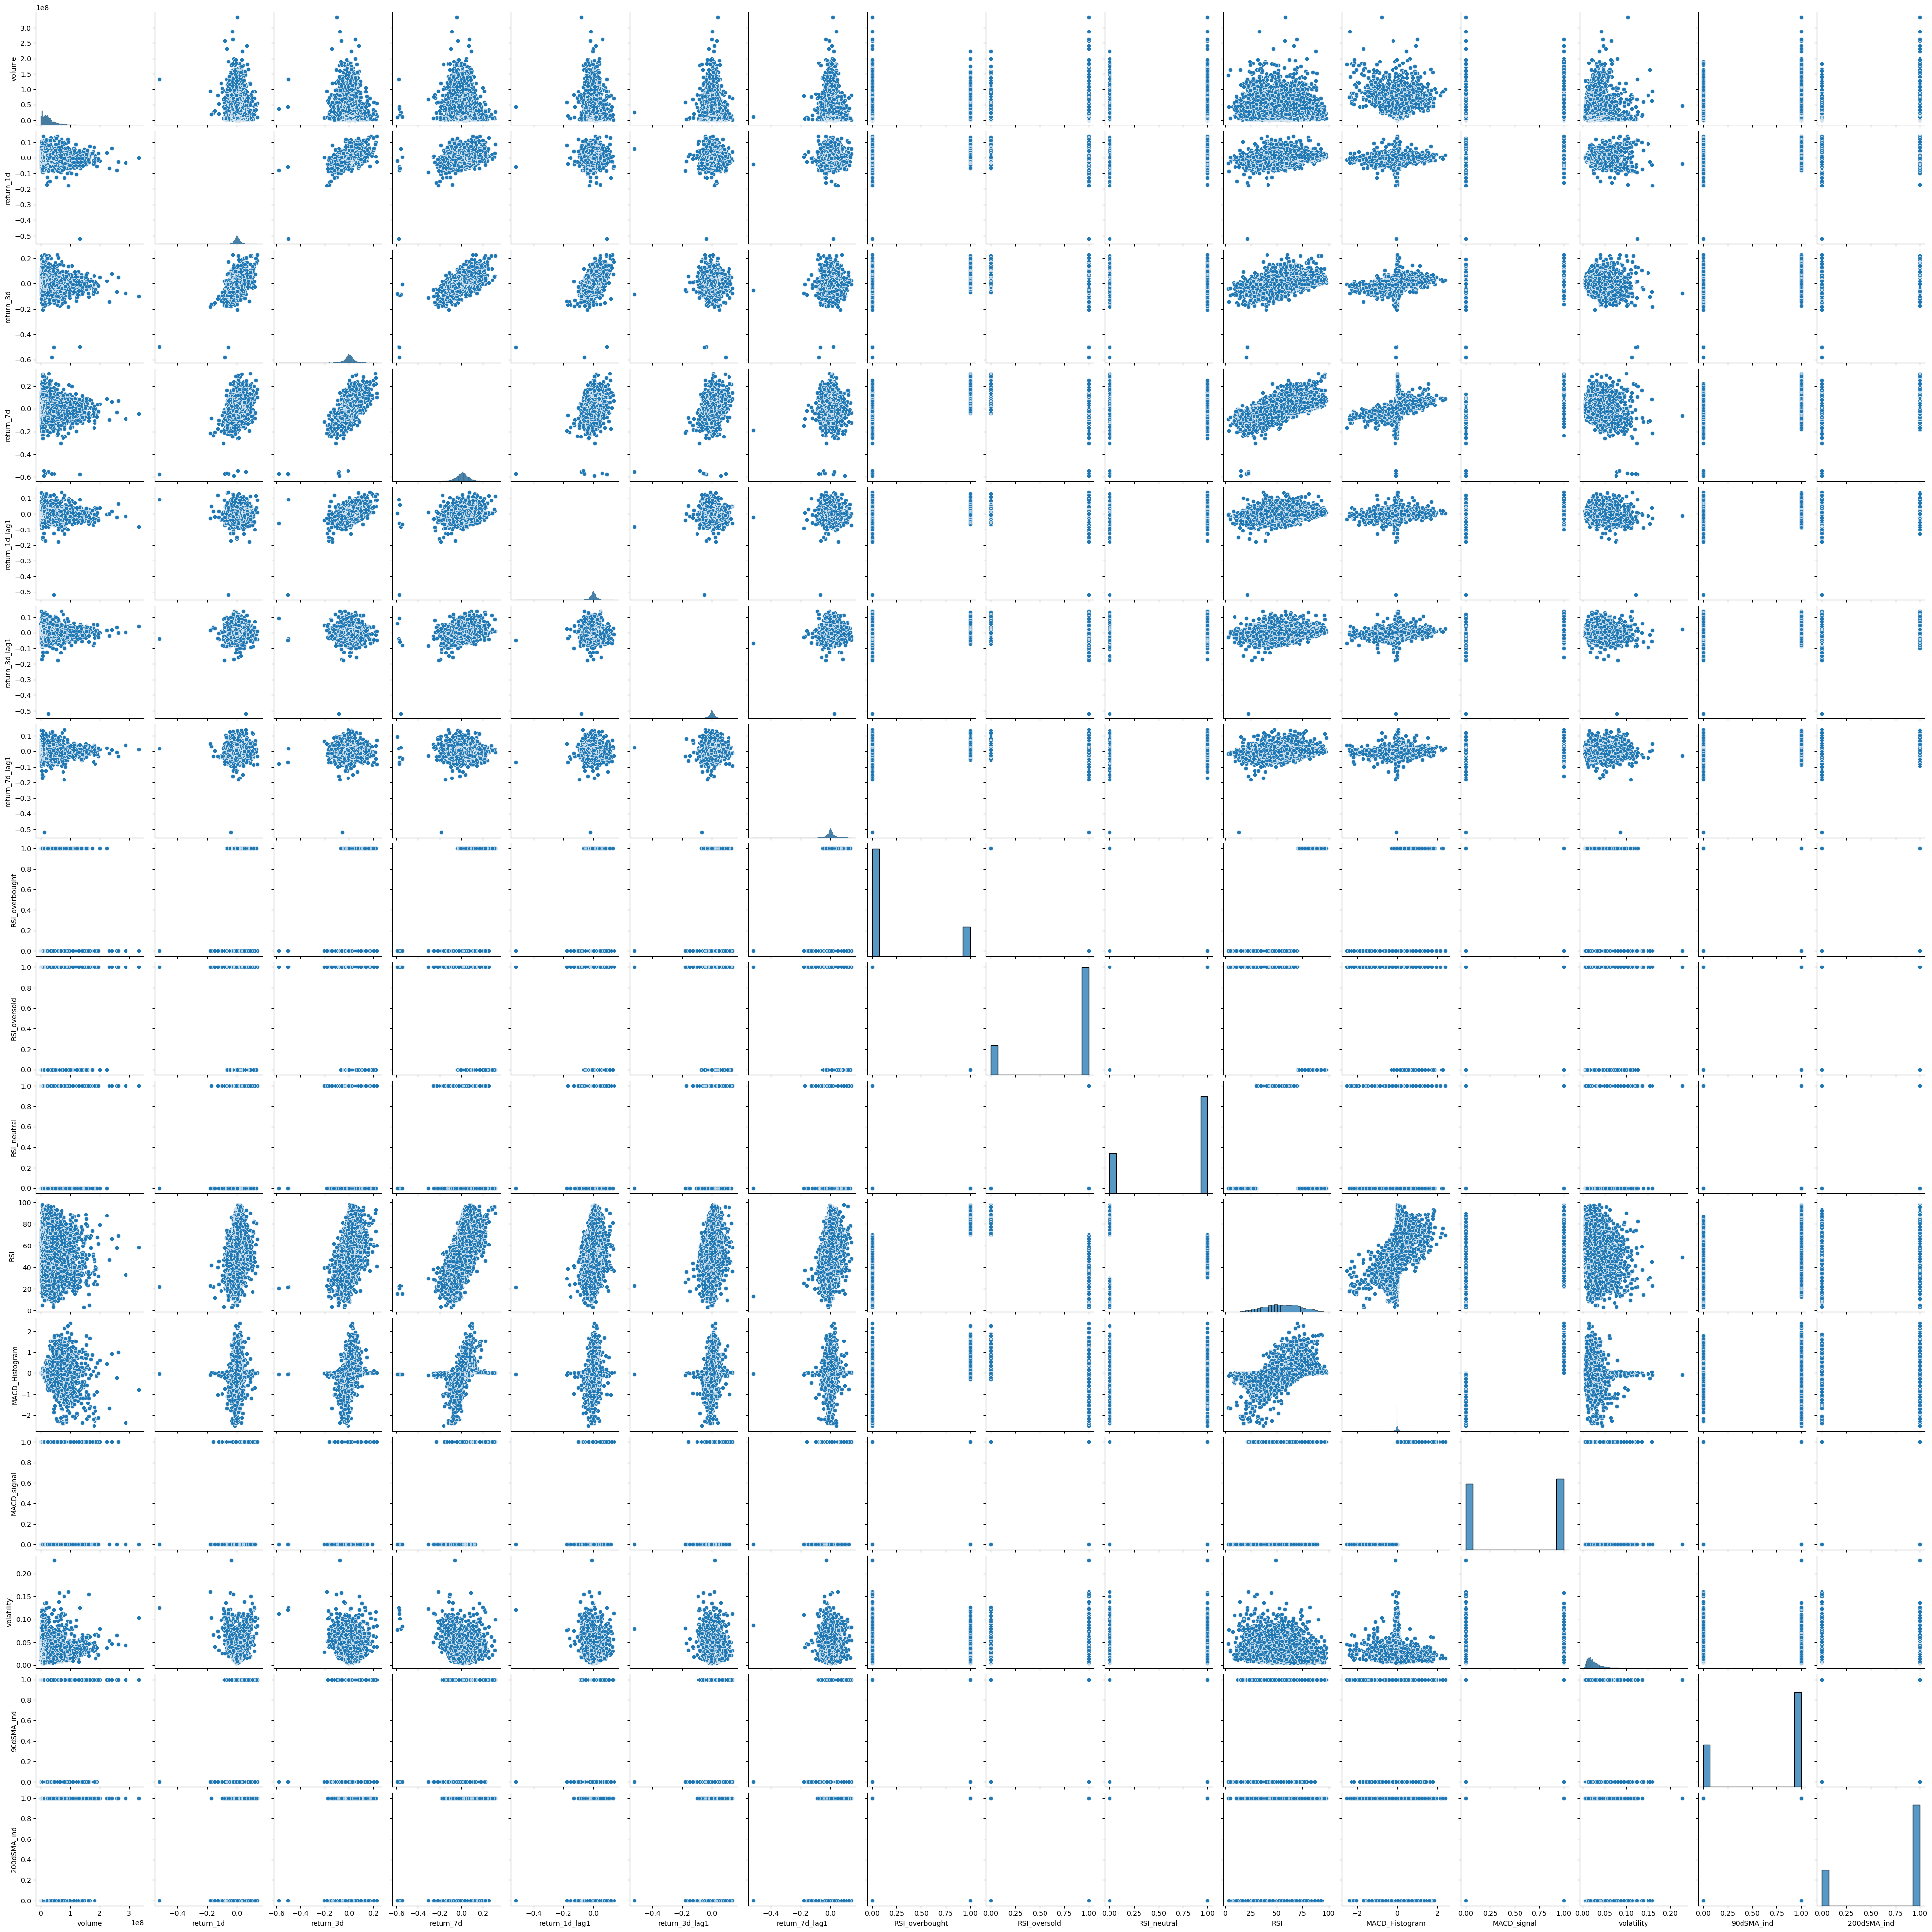

In [20]:
sns.pairplot(X_train)
plt.show()

There are 3 features which have a scale much different from the others - RSI, Volume and MACD historgram. I'll transform them using StandardScaler before proceeding to PCA analysis.

In [22]:
scaler_rsi = StandardScaler()
scaler_macd = StandardScaler()
scaler_vol = StandardScaler()

X_train['RSI'] = scaler_rsi.fit_transform(X_train.RSI.values.reshape(-1,1))
X_train['MACD_Histogram'] = scaler_macd.fit_transform(X_train['MACD_Histogram'].values.reshape(-1,1))
X_train['volume'] = scaler_vol.fit_transform(X_train['volume'].values.reshape(-1,1))


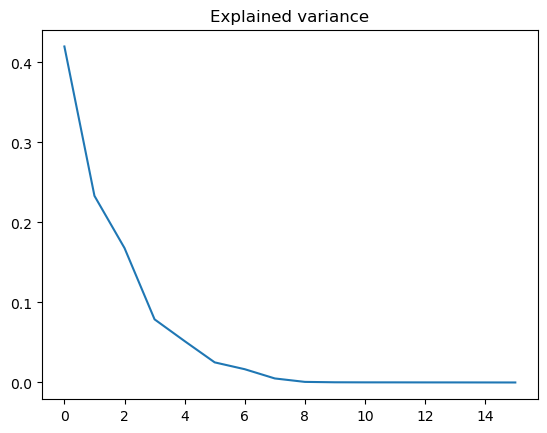

Explained variance of 3 main features: 82.12%


In [23]:
pca = PCA().fit(X_train)
plt.plot(pca.explained_variance_ratio_)
plt.title('Explained variance')
plt.show()
print(f'Explained variance of 3 main features: {round(pca.explained_variance_ratio_[:3].sum()*100, 2)}%')

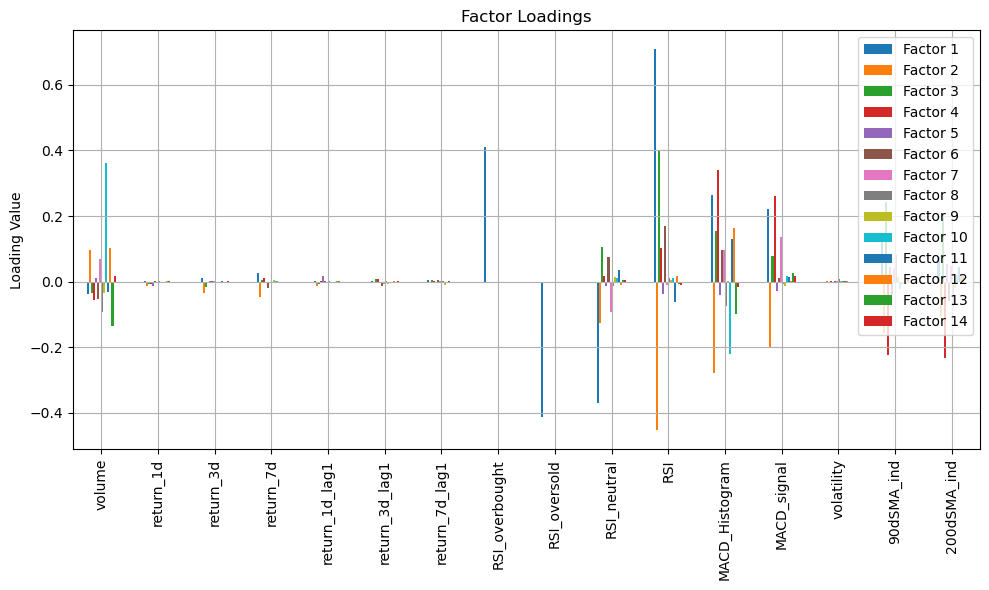

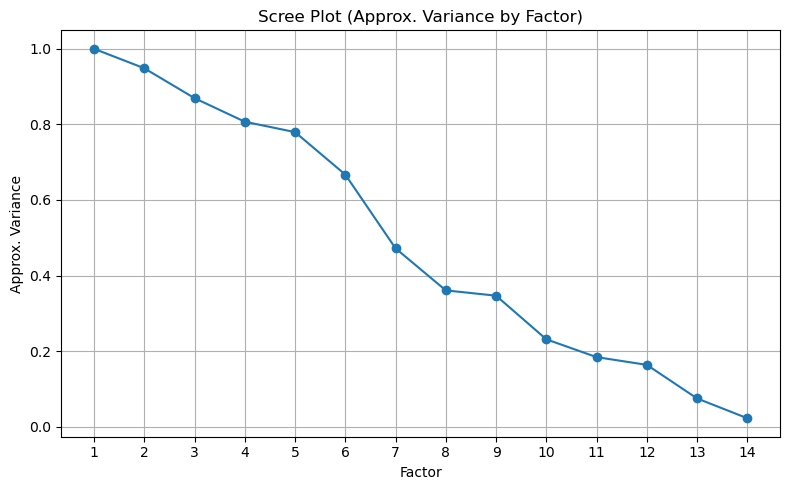

In [24]:
n_factors = 14
fa = FactorAnalysis(n_components=n_factors, random_state=42)
fa.fit(X_train)

# Get loadings (components_.T: shape = n_features x n_factors)
loadings = pd.DataFrame(fa.components_.T, index=X_train.columns, columns=[f"Factor {i+1}" for i in range(n_factors)])

# Plot loadings as bar chart
loadings.plot(kind='bar', figsize=(10, 6))
plt.title("Factor Loadings")
plt.ylabel("Loading Value")
plt.grid(True)
plt.tight_layout()
plt.show()

# Approximate variance explained by each factor (sum of squared loadings per factor)
scree_values = np.var(fa.transform(X_train), axis=0)

# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, n_factors + 1), scree_values, marker='o')
plt.title("Scree Plot (Approx. Variance by Factor)")
plt.xlabel("Factor")
plt.ylabel("Approx. Variance")
plt.xticks(range(1, n_factors + 1))
plt.grid(True)
plt.tight_layout()
plt.show()

PCA and Factor Analysis show that there are ca.9 major features out of the proposed set. Factor Analysis suggests that RSI and MACD histogram are of most importance.<br>

Based on PCA analysis, 3 main features explain more than 80% of variance. I'll make a 3D visualization of the dataset to check for any patterns/insights.

In [26]:
# make a DataFrame with chart data

pca_chart_df = pd.DataFrame(PCA(n_components=3).fit_transform(X_train), columns=['Feature 1', 'Feature 2', 'Feature 3'])
pca_chart_df['Class'] = y_train.astype(str)  # Add labels as a column

fig = px.scatter_3d(
    pca_chart_df,
    x='Feature 1',
    y='Feature 2',
    z='Feature 3',
    color='Class',
    color_discrete_sequence=px.colors.qualitative.Dark2,
    title='3D Dataset Visualization',
    opacity=0.5,
    height=700,
    hover_data={'Class': True}  # Show class on hover
)

fig.update_layout(
    scene=dict(
        xaxis_title='Feature 1',
        yaxis_title='Feature 2',
        zaxis_title='Feature 3',
        camera=dict(eye=dict(x=1.5, y=1.5, z=0.1))  # Adjust default camera angle
), showlegend=True
)

fig.show()

From above visualization we see that the classes are highly overlapping, which makes it challenging to get the right model.
<br>
I will focus on models, which are more capable for dealing with non-linear datasets, such as Random Forest, Gradient Boosting, XGBoost CatBoost and Support Vector Machine (with rbf kernel).

<h2>Model selection</h2>
At first step I will try to fit a range of models based with default parameters to get the feeling of general performance. I will check the performance using 5-fold cross-validation. Since we are dealing with time series data, I use TimeSeriesSplit to generate necessary data chunks.

Model Random Forest started
Model Gradient Boosting started
Model Support Vector Machine started
Model XGBoost started
Model CatBoost started
                classifier     score  cv_chunk  features_number
13  Support Vector Machine  0.644494      4045               16
7        Gradient Boosting  0.619305      3034               16
12  Support Vector Machine  0.603743      3034               16
22                CatBoost  0.598319      3034               16
11  Support Vector Machine  0.595469      2023               16
14  Support Vector Machine  0.584133      5056               16
17                 XGBoost  0.564011      3034               16
4            Random Forest  0.562500      5056               16
21                CatBoost  0.560955      2023               16
2            Random Forest  0.553931      3034               16


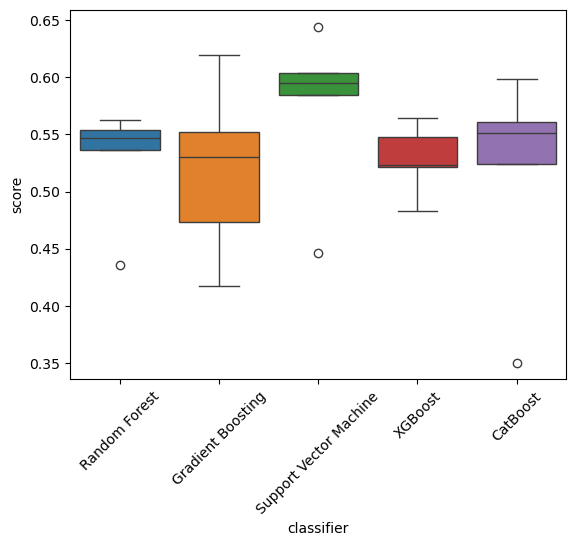

In [29]:
classifiers = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Support Vector Machine": SVC(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "CatBoost": CatBoostClassifier(verbose=False)
}

tms_cv = TimeSeriesSplit(n_splits=5, gap=2)

results = pd.DataFrame(columns=['classifier', 'score', 'cv_chunk', 'features_number'])

for k in classifiers.keys():
    print(f'Model {k} started')
    for train_ind, test_ind in tms_cv.split(X_train):
        model = classifiers[k]
        model.fit(X_train.iloc[train_ind, :], y_train[train_ind])
        results.loc[len(results)] = [k, f1_score(y_train[test_ind], model.predict(X_train.iloc[test_ind, :])), train_ind.max(), len(X_train.columns)]

print(results.sort_values('score', ascending=False).head(10))

sns.boxplot(data=results, y='score', x='classifier', hue='classifier')
plt.xticks(rotation=45)
plt.show()

I will try to use PCA to reduce number of features used and check whether this can improve performance of any model. Based on previous analysis, it doesn't make sense to use more than 10 and less than 4 components.

In [31]:
for n in range(4, 11, 1):
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train)

    for k in classifiers.keys():
        print(f'Model {k} started - with {n} components')

        for train_ind, test_ind in tms_cv.split(X_train):
            model = classifiers[k]
            model.fit(X_train.iloc[train_ind, :], y_train[train_ind])
            results.loc[len(results)] = [k, f1_score(y_train[test_ind], model.predict(X_train.iloc[test_ind, :])), train_ind.max(), n]


Model Random Forest started - with 4 components
Model Gradient Boosting started - with 4 components
Model Support Vector Machine started - with 4 components
Model XGBoost started - with 4 components
Model CatBoost started - with 4 components
Model Random Forest started - with 5 components
Model Gradient Boosting started - with 5 components
Model Support Vector Machine started - with 5 components
Model XGBoost started - with 5 components
Model CatBoost started - with 5 components
Model Random Forest started - with 6 components
Model Gradient Boosting started - with 6 components
Model Support Vector Machine started - with 6 components
Model XGBoost started - with 6 components
Model CatBoost started - with 6 components
Model Random Forest started - with 7 components
Model Gradient Boosting started - with 7 components
Model Support Vector Machine started - with 7 components
Model XGBoost started - with 7 components
Model CatBoost started - with 7 components
Model Random Forest started - wi

In [32]:
results.groupby('classifier').mean('score').sort_values('score', ascending=False)

score  cv_chunk  features_number
classifier                                                 
Support Vector Machine  0.574751    3034.0            8.125
XGBoost                 0.527903    3034.0            8.125
Random Forest           0.522090    3034.0            8.125
Gradient Boosting       0.517039    3034.0            8.125
CatBoost                0.516944    3034.0            8.125

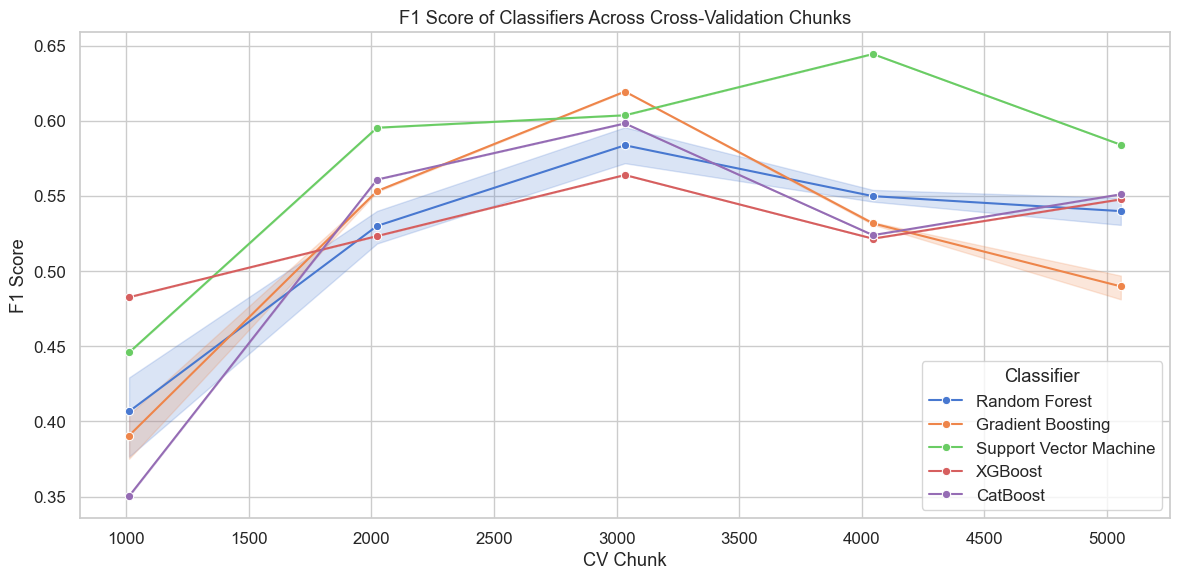

In [33]:
# Set seaborn style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Create a lineplot showing performance across CV chunks for each classifier
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results,
    x="cv_chunk",
    y="score",
    hue="classifier",
    marker="o"
)

# Customize the plot
plt.title("F1 Score of Classifiers Across Cross-Validation Chunks")
plt.xlabel("CV Chunk")
plt.ylabel("F1 Score")
plt.legend(title="Classifier")
plt.tight_layout()
plt.show()

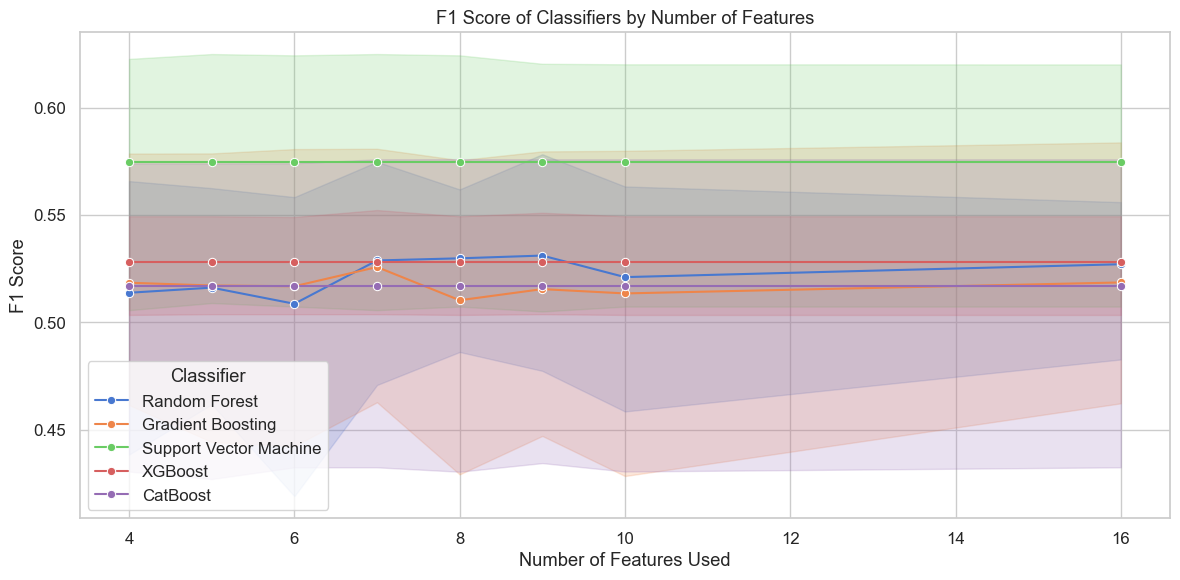

In [34]:
# Create a lineplot showing performance by number of features used
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=results,
    x="features_number",
    y="score",
    hue="classifier",
    marker="o"
)

plt.title("F1 Score of Classifiers by Number of Features")
plt.xlabel("Number of Features Used")
plt.ylabel("F1 Score")
plt.legend(title="Classifier")
plt.tight_layout()
plt.show()

Based on the above charts we can make several conclusions about models behaviour:
<li>Models' performance changes at different sets of data with worst performance on the first chunk. It can be explained either by lack of data or change in share price behaviour over time</li>
<li>Support Vector Machine shows better performance in most of the cases</li>
<li>KNN model improves performance on more fresh data</li>
<li>Gradient Boosting experiences substantial drop in performance. It is worth to fine-tune the model and check whether it can perform better</li>
<br>
As for number of features used, most models aren't sensitive to the number of features with slight improvement of RandomForest in case of full set.
<br>
For further selection I decided to use all features and omit first 1,000 datapoints.
<br>
<br>
First, I update training set.

In [58]:
X_train_selected = stock_data[:'2024-01-01']
X_train_selected = X_train_selected[1000:]
y_train_selected = y_train[1000:]

# check that number of datapoints is equal
print(X_train_selected.shape)
print(y_train_selected.shape)

(5070, 17)
(5070,)


<h3>Models fine-tuning</h3>

In [61]:
# dictionary with set of models to fine-tune
models = {
    'rf': RandomForestClassifier(random_state=42),
    'svm': SVC(probability=True),  # `probability=True` for compatibility with AUC scoring
    'cat': CatBoostClassifier(verbose=0, random_state=42),
    'xgb': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'gb': GradientBoostingClassifier(random_state=42)
}

# dictionary with parameters for models
param_grid = {
    'rf': {
        'n_estimators': [100, 200, 500],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    'svm': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf'],
        'gamma': ['scale', 'auto'],
    },
    'cat': {
        'iterations': [100, 300, 500],
        'learning_rate': [0.01, 0.05, 0.1],
        'depth': [4, 6, 8],
        'l2_leaf_reg': [1, 3, 5, 7],
        'border_count': [32, 64, 128]
    },
    'xgb': {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 9],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    },
    'gb': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

# dataframe to store results
fine_tuning_results = pd.DataFrame(columns=['f1_score', 'classifier', 'best_params'])

for name in models.keys():
    print(f'Model {name} started')
    best_score, best_params = run_grid_search(models[name], param_grid[name], X_train_selected, y_train_selected, cv=tms_cv)
    print(f'Model {name} best score is: {best_score}\n\n')
    fine_tuning_results.loc[len(fine_tuning_results)] = [best_score, name, best_params]
    

Model rf started
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Model rf best score is: 0.9995495495495496


Model svm started
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Model svm best score is: 0.6918637982870658


Model cat started
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Model cat best score is: 0.999117584106785


Model xgb started
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Model xgb best score is: 0.9977758896279099


Model gb started
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Model gb best score is: 0.9995495495495496




In [63]:
fine_tuning_results

f1_score classifier                                        best_params
0  0.999550         rf  {'bootstrap': True, 'max_depth': None, 'min_sa...
1  0.691864        svm      {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
2  0.999118        cat  {'border_count': 128, 'depth': 4, 'iterations'...
3  0.997776        xgb  {'colsample_bytree': 0.6, 'learning_rate': 0.0...
4  0.999550         gb  {'learning_rate': 0.01, 'max_depth': 3, 'min_s...

In [65]:
# initializing models for further test
model_classes = {
    'rf': RandomForestClassifier,
    'svm': SVC,
    'cat': CatBoostClassifier,
    'xgb': XGBClassifier,
    'gb': GradientBoostingClassifier
}

final_models = {
    row['classifier']: model_classes[row['classifier']](**row['best_params'])
    for _, row in fine_tuning_results.iterrows()
}

In [67]:
X_test['RSI'] = scaler_rsi.transform(X_test.RSI.values.reshape(-1,1))
X_test['MACD_Histogram'] = scaler_macd.transform(X_test['MACD_Histogram'].values.reshape(-1,1))
X_test['volume'] = scaler_vol.transform(X_test['volume'].values.reshape(-1,1))

For final test I check performance of the models on unseen data (F1 score) and confusion matrix for better understanding.

Model rf 
 F1 score on test data is 0.5384615384615384


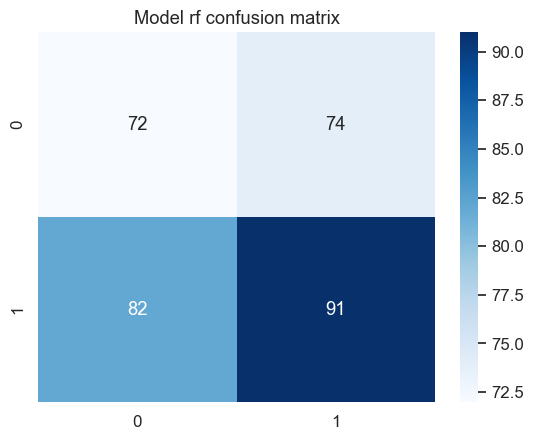

Model svm 
 F1 score on test data is 0.7032520325203252


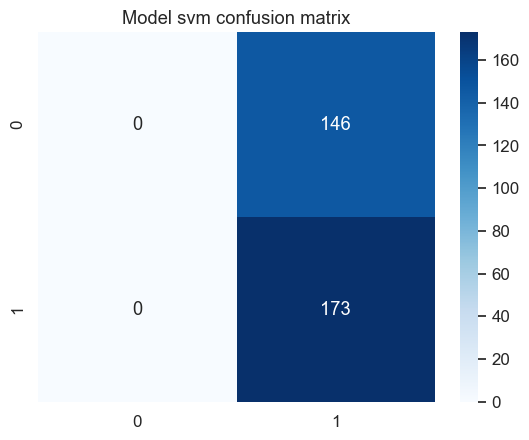

0:	learn: 0.6930393	total: 2.05ms	remaining: 203ms
1:	learn: 0.6929995	total: 4.33ms	remaining: 212ms
2:	learn: 0.6929073	total: 5.73ms	remaining: 185ms
3:	learn: 0.6928138	total: 7.05ms	remaining: 169ms
4:	learn: 0.6927545	total: 9.18ms	remaining: 174ms
5:	learn: 0.6926921	total: 11.3ms	remaining: 177ms
6:	learn: 0.6926024	total: 13.5ms	remaining: 180ms
7:	learn: 0.6925207	total: 14.7ms	remaining: 169ms
8:	learn: 0.6924558	total: 16ms	remaining: 162ms
9:	learn: 0.6923854	total: 17.7ms	remaining: 160ms
10:	learn: 0.6923251	total: 19.5ms	remaining: 158ms
11:	learn: 0.6922646	total: 20.9ms	remaining: 154ms
12:	learn: 0.6921917	total: 22.1ms	remaining: 148ms
13:	learn: 0.6921430	total: 23.3ms	remaining: 143ms
14:	learn: 0.6920640	total: 24.5ms	remaining: 139ms
15:	learn: 0.6919654	total: 25.8ms	remaining: 135ms
16:	learn: 0.6919073	total: 27ms	remaining: 132ms
17:	learn: 0.6918262	total: 28.1ms	remaining: 128ms
18:	learn: 0.6917529	total: 29.3ms	remaining: 125ms
19:	learn: 0.6917050	total

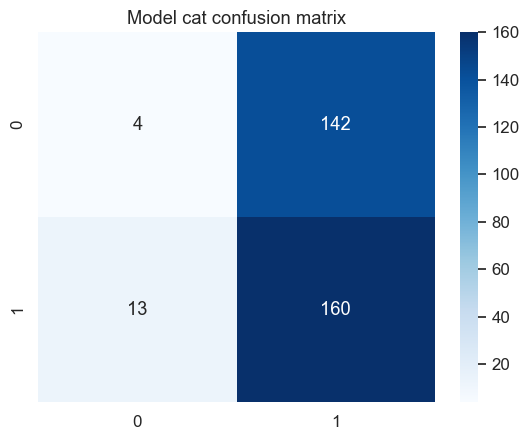

Model xgb 
 F1 score on test data is 0.6864406779661016


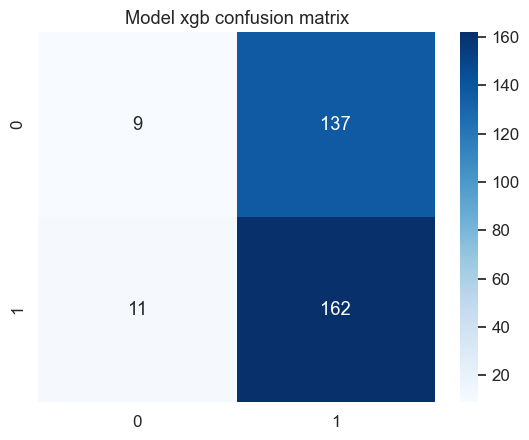

Model gb 
 F1 score on test data is 0.6410835214446953


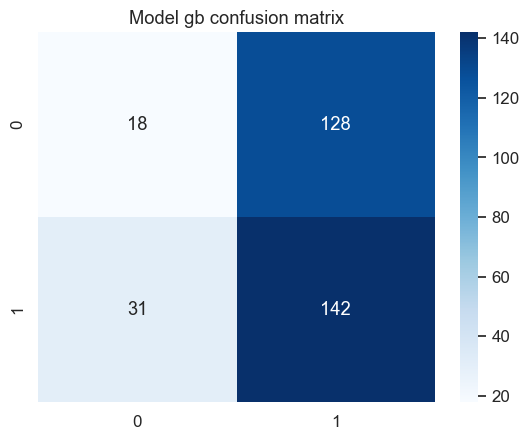

In [70]:
for name in final_models.keys():
    model = final_models[name]
    model.fit(X_train[1000:], y_train[1000:])
    y_pred = model.predict(X_test)
    print(f'Model {name} \n F1 score on test data is {f1_score(y_test, y_pred)}')

    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Model {name} confusion matrix')
    
    plt.show()

All the models show rather poor performance for actual use. While F1 score is pretty high for all except for RandomForest, the models fail to predict one class (negative price movement in this particular case). It makes sense to check ROC-AUC curve and adjust probability threshold to cure the imbalance.

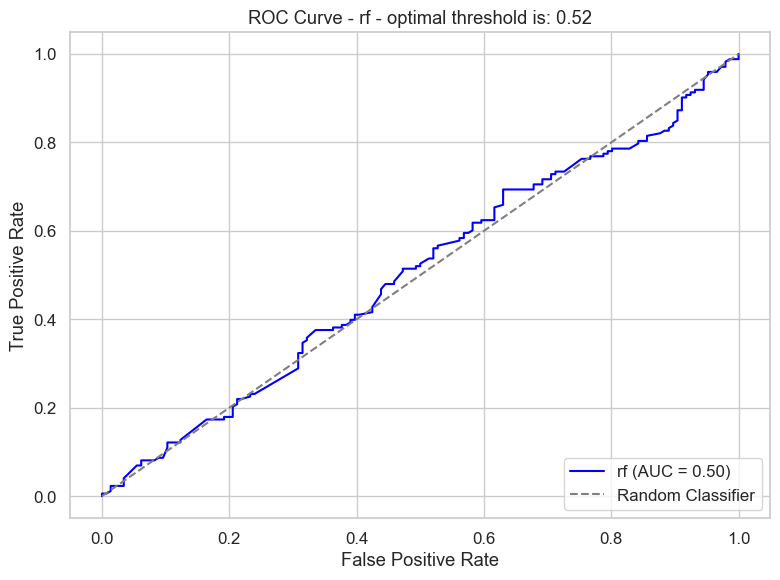

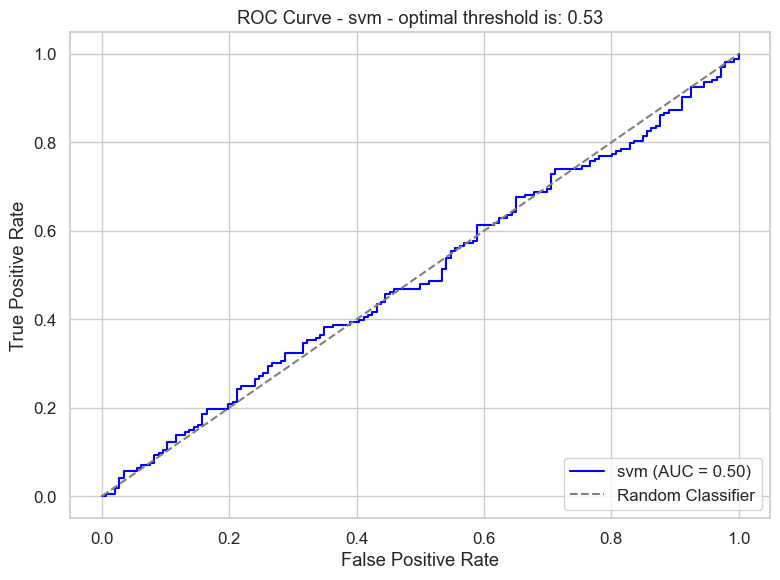

0:	learn: 0.6930393	total: 6.71ms	remaining: 664ms
1:	learn: 0.6929995	total: 10.1ms	remaining: 497ms
2:	learn: 0.6929073	total: 13.6ms	remaining: 441ms
3:	learn: 0.6928138	total: 16.5ms	remaining: 397ms
4:	learn: 0.6927545	total: 19.6ms	remaining: 373ms
5:	learn: 0.6926921	total: 23ms	remaining: 361ms
6:	learn: 0.6926024	total: 26.6ms	remaining: 354ms
7:	learn: 0.6925207	total: 29.8ms	remaining: 342ms
8:	learn: 0.6924558	total: 32.8ms	remaining: 332ms
9:	learn: 0.6923854	total: 36.1ms	remaining: 325ms
10:	learn: 0.6923251	total: 40.1ms	remaining: 324ms
11:	learn: 0.6922646	total: 43.3ms	remaining: 318ms
12:	learn: 0.6921917	total: 46.6ms	remaining: 312ms
13:	learn: 0.6921430	total: 49.7ms	remaining: 305ms
14:	learn: 0.6920640	total: 52.8ms	remaining: 299ms
15:	learn: 0.6919654	total: 56.1ms	remaining: 295ms
16:	learn: 0.6919073	total: 59.5ms	remaining: 290ms
17:	learn: 0.6918262	total: 63.1ms	remaining: 288ms
18:	learn: 0.6917529	total: 66.2ms	remaining: 282ms
19:	learn: 0.6917050	tot

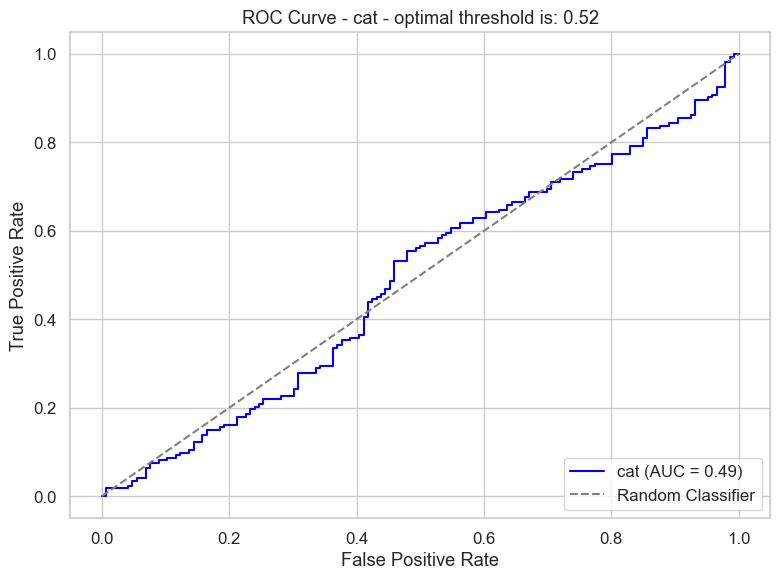

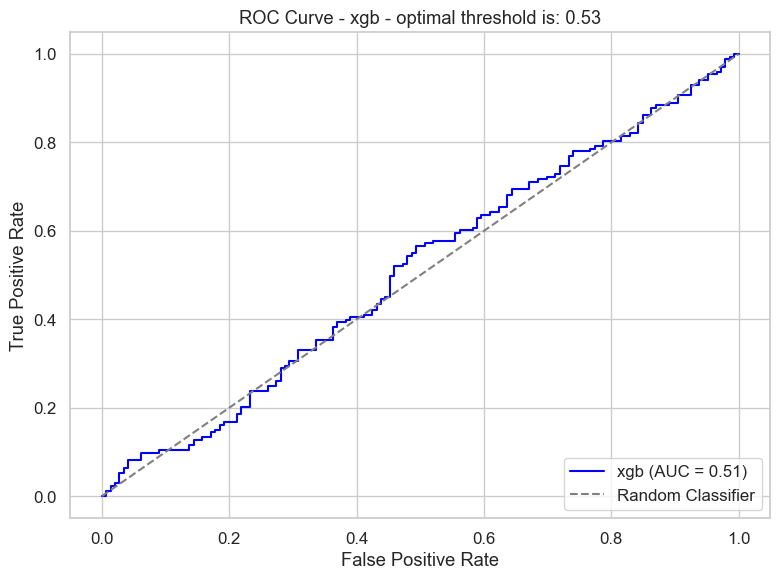

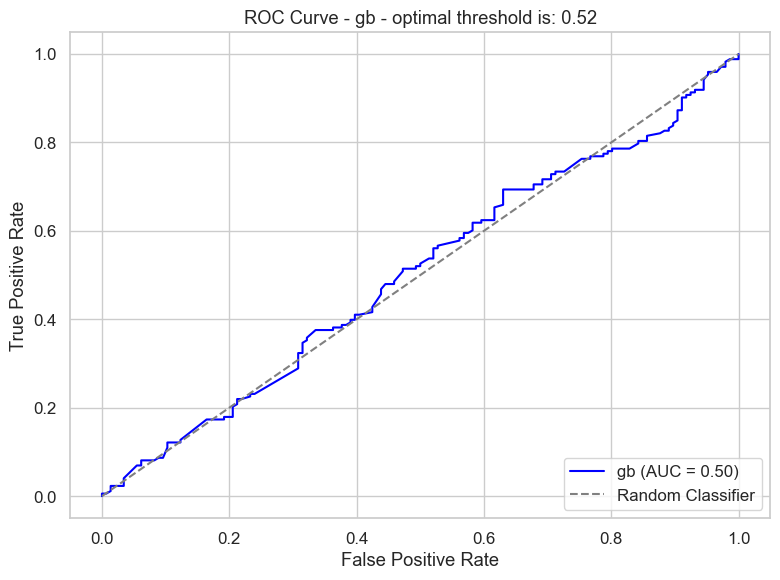

In [75]:
for name in final_models.keys():
    if name in ['cat', 'xgb', 'gb']:
    
        model = final_models[name]
        
    elif name == 'svm':
        
        model = SVC(C=0.1, gamma='scale', kernel='rbf', probability=True)

    else:
        next
        
    model.fit(X_train[1000:], y_train[1000:])
    y_pred = model.predict_proba(X_test)[:, 1]

    plot_roc_auc(y_test, y_pred, name)

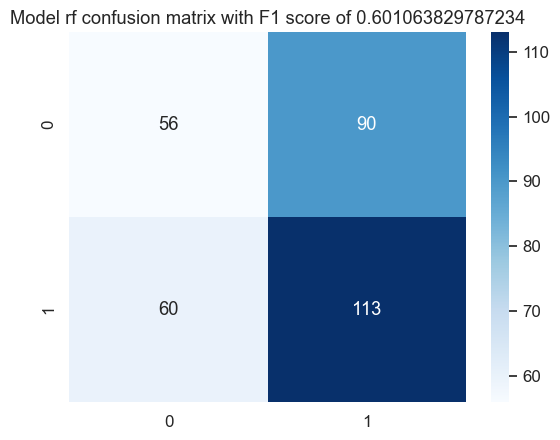

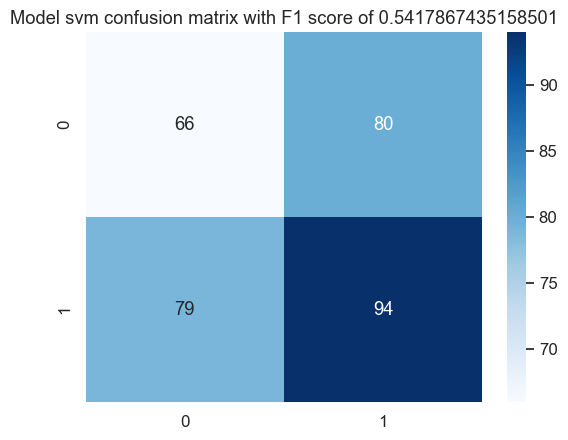

0:	learn: 0.6930393	total: 5.94ms	remaining: 588ms
1:	learn: 0.6929995	total: 10.3ms	remaining: 503ms
2:	learn: 0.6929073	total: 13.5ms	remaining: 435ms
3:	learn: 0.6928138	total: 17.1ms	remaining: 410ms
4:	learn: 0.6927545	total: 20.1ms	remaining: 382ms
5:	learn: 0.6926921	total: 23.2ms	remaining: 364ms
6:	learn: 0.6926024	total: 26.5ms	remaining: 352ms
7:	learn: 0.6925207	total: 29.7ms	remaining: 341ms
8:	learn: 0.6924558	total: 32.9ms	remaining: 333ms
9:	learn: 0.6923854	total: 36ms	remaining: 324ms
10:	learn: 0.6923251	total: 38.9ms	remaining: 315ms
11:	learn: 0.6922646	total: 41.7ms	remaining: 306ms
12:	learn: 0.6921917	total: 45.1ms	remaining: 302ms
13:	learn: 0.6921430	total: 48.7ms	remaining: 299ms
14:	learn: 0.6920640	total: 51.9ms	remaining: 294ms
15:	learn: 0.6919654	total: 54.8ms	remaining: 288ms
16:	learn: 0.6919073	total: 57.9ms	remaining: 283ms
17:	learn: 0.6918262	total: 61.3ms	remaining: 279ms
18:	learn: 0.6917529	total: 64.4ms	remaining: 275ms
19:	learn: 0.6917050	tot

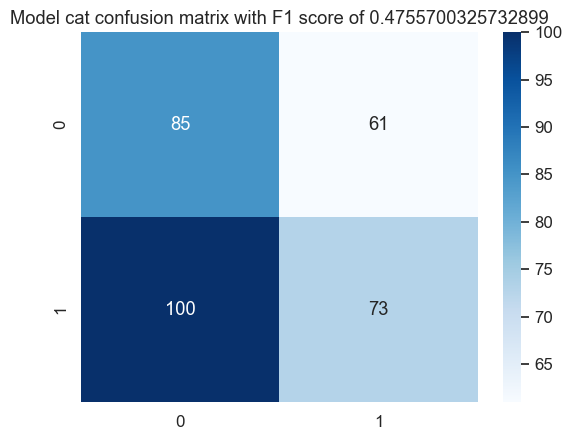

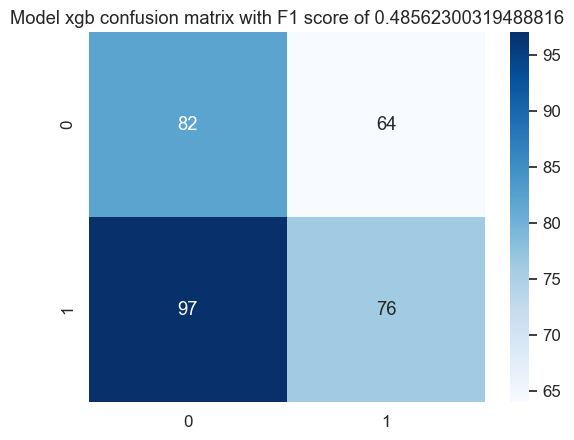

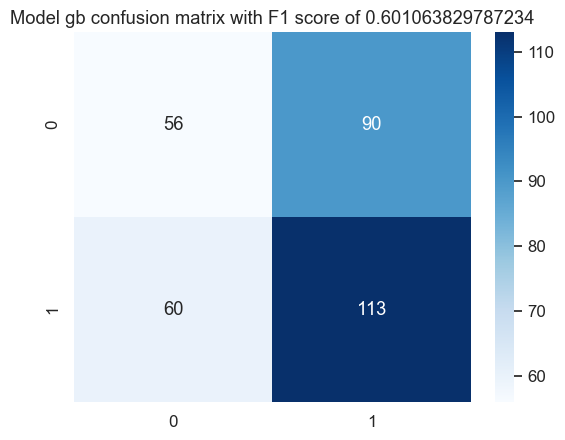

In [79]:
thresholds = {
    'cat': 0.52,
    'gb': 0.52,
    'xgb': 0.53,
    'svm': 0.53,
    'rf': 0.52
}

for name in final_models.keys():
    if name in ['cat', 'xgb', 'gb']:
    
        model = final_models[name]
        
    elif name == 'svm':
        
        model = SVC(C=0.1, gamma='scale', kernel='rbf', probability=True)

    model.fit(X_train[1000:], y_train[1000:])
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > thresholds[name])

    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Model {name} confusion matrix with F1 score of {f1_score(y_test, y_pred)}')
    
    plt.show()

While the models are still not ideal in terms of prediction power, I'll use RandomForest model with adjusted threshold of 0.52 for final version of the model. In the next section I'll make a pipeline for a final model ready for deployment.

In [102]:
print(final_models['rf'].get_params())
fine_tuning_results.best_params.loc[0]

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


{'bootstrap': True,
 'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [110]:
X_final_training = stock_data.drop(['target'], axis=1)
y_final_training = stock_data['target'].values

X_final_training = X_final_training.iloc[1000:, :]
y_final_training = y_final_training[1000:]
y_final_training = (y_final_training > 0).astype(int)


scale_features = ['RSI', 'MACD_Histogram', 'volume']

scaler = ColumnTransformer(
        transformers=[
            ('scaler', StandardScaler(), scale_features)
        ],
        remainder='passthrough')

rf_pipeline = Pipeline([
        ('scaling', scaler),
        ('classifier', final_models['rf'])
])

rf_pipeline.fit(X_final_training, y_final_training)

print(f'RF Test score: {f1_score(y_test, rf_pipeline.predict(X_test))}')

RF Test score: 0.6576271186440678


In [116]:
# saving the model for further deployment
joblib.dump(rf_pipeline, 'AAPL_classifier.pkl')

['AAPL_classifier.pkl']

In [118]:
# testing that the model functions correctly on test data
test_mod = joblib.load('AAPL_classifier.pkl')
f1_score(y_test, test_mod.predict(X_test))

0.6576271186440678